In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import fft
from skimage.transform import resize
import math
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os


Give it a waveform - from there we strip out the zeros. This should probably all happen as we pre-process the data into a single data store.

In [2]:
def read_waveform(f_name, strip_zeros=True):
    file = open(f_name, "r")
    # skip the first 13 lines of header
    lines = file.readlines()[13:]
    data = np.array(lines).astype('float32')
    if strip_zeros:
        return data[data != 0.]
    else:
        return data

This now reads in one of the data files, grabs the channel, hit,time and waveform data and returns it as a dict

In [3]:
def read_data_file(f_name, strip_zeros=True):
    data_dict = {}
    file = open(f_name, "r")
    # skip the first 13 lines of header
    all_data = file.readlines()
    data_dict['channel'] = int(all_data[8].split(' ')[-1])
    data_dict['hit'] = int(all_data[9].split(' ')[-1])
    data_dict['time'] = float(all_data[10].strip('\n').split(' ')[-1])
    # get the waveform
    wave = all_data[13:]
    data_array = np.array(wave).astype('float32')
    # strip zeros
    data_dict['waveform'] = data_array[data_array != 0.]
    return data_dict


Pinched some of this from a stackoverflow posting. We'll calculate the spectrogram using scipy's FFT tools. Pretty straightforward. The Pxx value puts the data into log space which I believe is to keep the measurement in dB - though I'm not 100% on that. We should understand what's happening in this function in order to detail it in the writeup for sure. I'm not super clear on the complex number math that's happening here.

In [4]:
# from: https://stackoverflow.com/questions/63640027/spectrogram-in-python-using-numpy

def make_spectrogram(waveform, N=100, rate=5000000):
    """Create and return a spectrogram array"""
    # Where to put the spectrogram
    S = []
    for k in range(0, waveform.shape[0]+1, N):
        x = fft.fftshift(fft.fft(waveform[k:k+N], n=N))[N//2:N]
        Pxx = 10*np.log10(np.real(x*np.conj(x)))
        S.append(Pxx)
    S = np.array(S)

    # Calc Frequencies - don't return those yet
#     f = fft.fftshift(fft.fftfreq(N, d=1/rate))[N//2:N]
#     print('freqs', f)
    return S.T

Using this to normalize the FFT matrix

In [5]:
def normalize_data(data):
    """Normalize an array 0-1"""
    return (data - np.min(data)) / (np.max(data) - np.min(data)+.000001)

This function uses PIL to do a resize on the spectrogram so we can have a consistent size. The samples are all of consistent length (as ar as I can tell) but the zero rows provide no information. So once those are remove the samples are of varying length. PIL can do an easy resize to consistent size - the question is do we use Nearest, so some form of interpolation to get there. 

In [17]:
def resize_data(data, newsize=(256, 256)):
    """Resize data using to a consistent size"""
    img = Image.fromarray(data, 'F')
    print('image data', img)
    #r_img = img.resize(newsize, Image.NEAREST)
    # no change in data values using the above 
    # or do we interpolate in the resize?
    r_img = img.resize(newsize, Image.BILINEAR)
    return np.asarray(r_img)

read in all the data to a pandas dataframe. We should split this to have a selectable amount of waveforms before and after so it's not overwhelming. Also we need to determine after which moment there is a crack in the test coupon so that this data can be labeled

In [7]:
fpath = './test_data/'
#using glob now to grab wildcard txt files
file_list = glob.glob(fpath + '*.txt')

data_columns = ['channel', 'hit', 'time', 'waveform', 'crack']
data = pd.DataFrame(columns=data_columns)

# limit the read
start=0
end=200
# set the crack time
crack_time = 345.

# read them all in
for n,file in enumerate(file_list[start:end]):
    data_in = read_data_file(file)
    data_in['crack'] = 0
    data = data.append(data_in, ignore_index=True)

# set all values after a specific time to be crack values
data.loc[data['time'] > crack_time, 'crack'] = 1
    
# put it in a time series
data.sort_values(['time'], ignore_index=True, inplace=True)

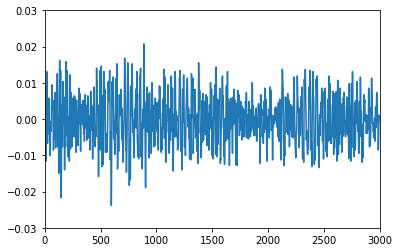

In [29]:
n=15
wave = data['waveform'][n][:3000]
#print(len(wave)
#print(len(wave[wave != 0]))
#print(np.where(wave==0))
plt.ylim(-.03, .03)
plt.xlim(0,3000)
plt.plot(wave)
plt.savefig(f'./sample_plots/waveform_{n}.jpg')

(288, 432, 3)


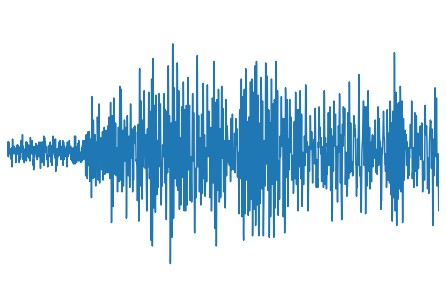

In [220]:

#plt.switch_backend('Agg')


def canvas2rgb_array(canvas):
    """Adapted from: https://stackoverflow.com/a/21940031/959926"""
    canvas.draw()
    buf = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    ncols, nrows = canvas.get_width_height()
    scale = round(math.sqrt(buf.size / 3 / nrows / ncols))
    return buf.reshape(scale * nrows, scale * ncols, 3)

fig, ax = plt.subplots()
plt.ylim(-.03, .03)
plt.xlim(0,3000)
plt.axis('off')

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.margins(0)
ax.plot(wave)

# Extract the plot as an array
plt_array = canvas2rgb_array(fig.canvas)
print(plt_array.shape)

190.18338477366254
image data <PIL.Image.Image image mode=F size=432x288 at 0x7FEE11096E50>
0.7106401074242076
[[0.9 0.9 0.9 ... 0.9 0.9 0.9]
 [0.9 0.9 0.9 ... 0.9 0.9 0.9]
 [0.9 0.9 0.9 ... 0.9 0.9 0.9]
 ...
 [0.9 0.9 0.9 ... 0.9 0.9 0.9]
 [0.9 0.9 0.9 ... 0.9 0.9 0.9]
 [0.9 0.9 0.9 ... 0.9 0.9 0.9]]


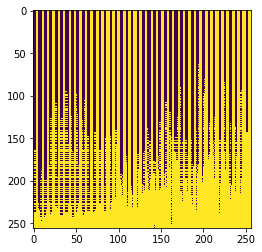

In [267]:
print(plt_array[...,0].mean())
#plt.axis("off")   # turns off axes
#plt.axis("tight")  # gets rid of white border
#plt.axis("image")  # square up the image instead of filling the "figure" space
wave_im = normalize_data(plt_array[...,0])
waver = resize_data(wave_im, (256, 256))
print(wave_im.mean())
print(wave_im-.1)
plt.imshow(waver)
#plt_array[...,1].mean(axis=0)

Still run the standard pre-processing

image data <PIL.Image.Image image mode=F size=39x39 at 0x7FCA389FDF90>
(256, 256)


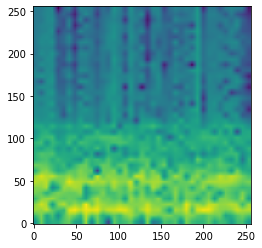

In [27]:
n=15
spec = make_spectrogram(data['waveform'][n][:3000], N=77)
n_spec = normalize_data(spec)
r_spec = resize_data(n_spec)
print(r_spec.shape)
plt.imshow(r_spec, origin='lower')
plt.savefig(f'./sample_plots/spectrogram_{n}.jpg')

and then pickle the data to disk in order to keep it compact and fast loading - 10,000 dta files consume ~150Mb of space when pickled.

In [9]:
data.to_pickle("./test_data_df.pkl") 

In [10]:
data.head()

,channel,hit,time,waveform,crack
0,1,1,32.459648,"[0.00030518, 0.00030518, 0.00030518, 0.0006103...",0
1,1,2,32.461310,"[-0.00305176, -0.0012207, 0.00061035, 0.003356...",0
2,1,3,35.044364,"[0.00213623, 0.0012207, 0.00030518, -0.0009155...",0
3,1,4,36.514689,"[0.00061035, 0.00091553, 0.0012207, 0.00091553...",0
4,1,5,38.035749,"[-0.00061035, 0.00061035, 0.00183105, 0.002136...",0


In [11]:
unpickled_df = pd.read_pickle("./test_data_df.pkl") 

In [12]:
unpickled_df.head()

,channel,hit,time,waveform,crack
0,1,1,32.459648,"[0.00030518, 0.00030518, 0.00030518, 0.0006103...",0
1,1,2,32.461310,"[-0.00305176, -0.0012207, 0.00061035, 0.003356...",0
2,1,3,35.044364,"[0.00213623, 0.0012207, 0.00030518, -0.0009155...",0
3,1,4,36.514689,"[0.00061035, 0.00091553, 0.0012207, 0.00091553...",0
4,1,5,38.035749,"[-0.00061035, 0.00061035, 0.00183105, 0.002136...",0


In [13]:
pd.__version__

'1.0.1'

# In Matplotlib:

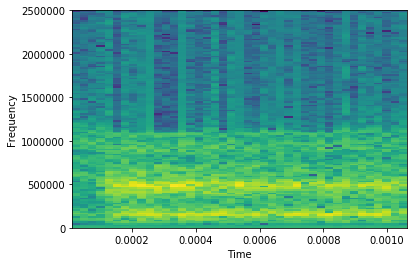

In [59]:
samplingFrequency = 5000000

# Plot the spectrogram
#plt.subplot(212)
powerSpectrum, frequenciesFound, time, im = plt.specgram(data['waveform'][0], Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

image data <PIL.Image.Image image mode=F size=256x256 at 0x7FEE60686DD0>
(256, 256)
new_spec -38.827557327273894 -20.31051952848358
n_new_spec 0.0 1.0
[[0.60649447 0.60494138 0.60338828 ... 0.61750091 0.61633694 0.61517298]
 [0.60620329 0.60462594 0.6030486  ... 0.61724317 0.61605778 0.61487238]
 [0.58742222 0.58428068 0.58113915 ... 0.60061921 0.59805148 0.59548375]
 ...
 [0.27956891 0.2795576  0.2795463  ... 0.37153922 0.36877727 0.36601531]
 [0.17537945 0.16252211 0.14966477 ... 0.28238587 0.27739981 0.27241375]
 [0.17376411 0.1607076  0.1476511  ... 0.28100365 0.27598311 0.27096257]]


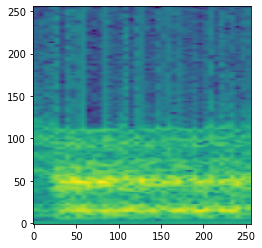

In [74]:
new_spec = resize(np.log(powerSpectrum), (256,256))
n_new_spec = normalize_data(new_spec)
r_new_spec = resize_data(n_new_spec)
plt.imshow(new_spec, origin='lower')
print(r_new_spec.shape)
print('new_spec', np.min(new_spec), np.max(new_spec))
print('n_new_spec', np.min(n_new_spec), np.max(n_new_spec))
print(n_new_spec)

#bottle_resized = resize(bottle, (140, 54))



In [79]:
plt.plot(data[0])
plt.show()

KeyError: 0